## Plot WROMY data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import nan
from pathlib import Path
from obspy import UTCDateTime, Stream

from andbro__get_timeaxis import __get_timeaxis

from functions.read_sds import __read_sds
from functions.load_furt_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

### Methods

In [3]:
def __reply(msg):
    print(f"   -> {msg}")

In [4]:
def __indicate_gaps_with_nan(df, config):
    
    differences = np.diff(df.totalSeconds, n=1)
    
    
    ## ______________
    
    sample_time_errors = [j for j in differences if j != config['resample']]

    if len(sample_time_errors) != 0:
        print(f"  -> ERROR: Found {len(sample_time_errors)} errors for the sampling time!\n")
    
    
    ## ______________
    
    gaps = [list(differences).index(k) for k in differences if k > 2*config['resample']] or []
    if gaps and gaps[0] in [0, 0.0]:
        gaps.pop(0)    
    del differences
    
    for x in gaps:
        fill_row = [i+config['resample'] if n not in [3,4,5] else np.nan for n, i in enumerate(df.iloc[x,:])]
        fill_row[0] = int(df.iloc[x,0])
        fill_row[1] = int(df.iloc[x,1])
        fill_row[2] = int(df.iloc[x,2])
        df.loc[x+0.5] = fill_row

    
    df = df.sort_index().reset_index(drop=True).convert_dtypes()

    print(f"  -> Marked {len(gaps)} gaps with NaN values!\n")
    
    return df

In [5]:
def __processing(data, config):
    
    filter_length = 10*config['resample']
    
    data.iloc[:,3:6] = data.iloc[:,3:6].rolling(filter_length).mean() 
    __reply(f"Filter: rooling mean {filter_length}!")
    
    data = data[data.index % config['resample'] == 0]
    __reply(f"Resampling: keep every {config['resample']}nth sample!")
    
    return data

In [6]:
def __read_wromy_data(config):
    '''
    reads data from T1 to T2
    '''

    from pandas import date_range
    from tqdm.notebook import tqdm_notebook

    df = pd.DataFrame()
    
    for n, date in enumerate(tqdm_notebook(date_range(config['tbeg'].date, config['tend'].date))):    
        doy = str(date.timetuple().tm_yday).rjust(3,"0")
        
        path = f"{config['pathToData']}{date.year}/BW/WROMY/{config['channel']}.D/"

        if not Path(path).exists():
            __reply(f"Path: {path}, does not exists!")
            return

    
        fileName = f"BW.WROMY.{config['channel']}.D.{date.year}.{doy}"

#         print(f'   reading {fileName} ...')

        try:
            df0 = pd.read_csv(path+fileName)
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
              
#             ## change time from in to 6 character string
            df0.iloc[:,2] = [str(ttt).rjust(6,"0") for ttt in df0.iloc[:,2]]
          
            if n == 1:
                df = df0
            else: 
                df = pd.concat([df,df0])
        except:
            __reply(f"File: {fileName}, does not exists!")
       
    
    df.reset_index(inplace=True, drop=True)

    ## add columns with total seconds
    if 'Seconds' in df.columns:
        totalSeconds = df.Seconds + (df.Date - df.Date.iloc[0]) * 86400
        df['totalSeconds'] = totalSeconds
    

    __reply("Done \n")
    
    return df 

In [7]:
def __read_furt_data(config, show_raw=False, path_to_archive = '/bay200/gif_online/FURT/WETTER/'):
    '''
    Load a selection of data of FURT weather station for time period

    PARAMETERS:
        - config:    configuration dictionary
        - show_raw:  bool (True/False) -> shows raw data FURT head


    RETURN:
        - dataframe
    '''

    from pathlib import Path
    from obspy import UTCDateTime
    from tqdm.notebook import tqdm_notebook
  
    config['tbeg'] = UTCDateTime(config['tbeg'])
    config['tend'] = UTCDateTime(config['tend'])
    
    output_text = []
    
    
    if not Path(path_to_archive).exists():
        output_text.append(f"  -> Path: {path_to_archive}, does not exists!")
#         print(f"  -> Path: {path_to_archive}, does not exists!")
        return    
    
    
    ## list of parameters requried in configurations
    params = ['tbeg', 'tend']
    for param in params:
        if not param in config.keys():
            output_text.append(f"ERROR: {param} not in config but required!")
#             print(f"ERROR: {param} not in config but required!")
            return
    
    
    ## declare empyt dataframe
    df = pd.DataFrame()
    
    for i, date in enumerate(tqdm_notebook(np.arange(config['tbeg'].date, (config['tend']+86400).date))):
        
        date = UTCDateTime(str(date)).date
        filename = f'FURT.WSX.D.{str(date.day).rjust(2,"0")}{str(date.month).rjust(2,"0")}{str(date.year).rjust(2,"0")[-2:]}.0000'
        
#         print(f'   reading {filename} ...')

        try:
            if show_raw:
                df0 = pd.read_csv(path_to_archive+filename)            
                print(df0.columns.tolist())
                return
            else:
                df0 = pd.read_csv(path_to_archive+filename, usecols=[0,1,10,12,13,14], names=['date', 'time', 'T', 'H', 'P','Rc'])            
            
            ## substitute strings with floats
            df0['T']  = df0['T'].str.split("=", expand=True)[1].str.split("C", expand=True)[0].astype(float)
            df0['P']  = df0['P'].str.split("=", expand=True)[1].str.split("H", expand=True)[0].astype(float)
            df0['H']  = df0['H'].str.split("=", expand=True)[1].str.split("P", expand=True)[0].astype(float)
            df0['Rc'] = df0['Rc'].str.split("=", expand=True)[1].str.split("M", expand=True)[0].astype(float)
           
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
            
            
            if df.empty:
                df = df0
            else: 
                df = pd.concat([df, df0])
        except:
            output_text.append(f"  -> File: {filename}, does not exists!")
#             print(f"  -> File: {filename}, does not exists!")
   
    df.reset_index(inplace=True, drop=True)
        
    for text in output_text:
        print(text)
        
    return df

### Configurations

In [8]:
config = {}

config['channel'] = None

config['tbeg'] = UTCDateTime("2021-01-01")
config['tend'] = UTCDateTime("2024-12-31")

config['pathToData'] = f'/import/freenas-ffb-01-data/romy_archive/'

config['resample'] = 20

config['colors'] = {  'WS1':'darkgreen', 
                      'WS4':'purple', 
                      'WS5':'darkred',
                      'WS6':'darkblue',
                      'WS7':'darkorange',
                      'WS8':'darkcyan',
                      'WS9':'cyan',
                     }

config['path_to_figs'] = "/import/kilauea_data/wromy/figures/"


## Read from seed

In [9]:
# furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')


In [10]:
ws = Stream()
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

ws = ws.merge();

ws

3 Trace(s) in Stream:
BW.WROMY.01.LKI | 2022-01-01T00:00:00.000000Z - 2024-10-17T23:59:59.000000Z | 1.0 Hz, 88214400 samples (masked)
BW.WROMY.09.LKI | 2023-03-24T00:00:00.000000Z - 2024-10-17T23:59:59.000000Z | 1.0 Hz, 49593600 samples (masked)
BW.WROMY.05.LKI | 2022-01-01T00:00:00.000000Z - 2024-10-17T23:59:59.000000Z | 1.0 Hz, 88214400 samples (masked)

In [ ]:
ws = ws.split()
ws = ws.decimate(10, no_filter=False)
ws = ws.merge(fill_value=np.nan)

In [ ]:
for tr in ws:
    plt.scatter(tr.times(reftime=config['tbeg'])/86400, tr.data, s=2)

plt.ylim(0, 30)

### Read from csv

In [ ]:
# # read data
# furt = __read_furt_data(config)

# # select subset
# furt = furt[['date', 'time', 'T', 'P', 'H', 'Rc']]

# # processing data
# furt = __processing(furt, config)

  0%|          | 0/730 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcdce178040>>
Traceback (most recent call last):
  File "/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcdce178040>>
Traceback (most recent call last):
  File "/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcdce178040>>
Traceback (most recent call last):
  File "/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/ipykernel/ipker

### Load WROMY Data

In [8]:
# data = {}

# # for i in [1, 4, 5, 6, 7, 8, 9]:

#     config['channel'] = 'WS'+str(i)

#     # load data as DataFrame
#     df_new = __read_wromy_data(config)

#     # check for gaps
# #     df_new = __indicate_gaps_with_nan(df_new, config)

#     # processing
# #     df_new = __processing(df_new, config)

#     # add to dictionary
#     data[config.get('channel')] = df_new

#     del df_new


  0%|          | 0/730 [00:00<?, ?it/s]

   -> File: BW.WROMY.WS4.D.2023.001, does not exists!
   -> File: BW.WROMY.WS4.D.2023.002, does not exists!
   -> File: BW.WROMY.WS4.D.2023.003, does not exists!
   -> File: BW.WROMY.WS4.D.2023.004, does not exists!
   -> File: BW.WROMY.WS4.D.2023.005, does not exists!
   -> File: BW.WROMY.WS4.D.2023.006, does not exists!
   -> File: BW.WROMY.WS4.D.2023.007, does not exists!
   -> File: BW.WROMY.WS4.D.2023.008, does not exists!
   -> File: BW.WROMY.WS4.D.2023.009, does not exists!
   -> File: BW.WROMY.WS4.D.2023.010, does not exists!
   -> File: BW.WROMY.WS4.D.2023.011, does not exists!
   -> File: BW.WROMY.WS4.D.2023.012, does not exists!
   -> File: BW.WROMY.WS4.D.2023.013, does not exists!
   -> File: BW.WROMY.WS4.D.2023.014, does not exists!
   -> File: BW.WROMY.WS4.D.2023.015, does not exists!
   -> File: BW.WROMY.WS4.D.2023.016, does not exists!
   -> File: BW.WROMY.WS4.D.2023.017, does not exists!
   -> File: BW.WROMY.WS4.D.2023.018, does not exists!
   -> File: BW.WROMY.WS4.D.2

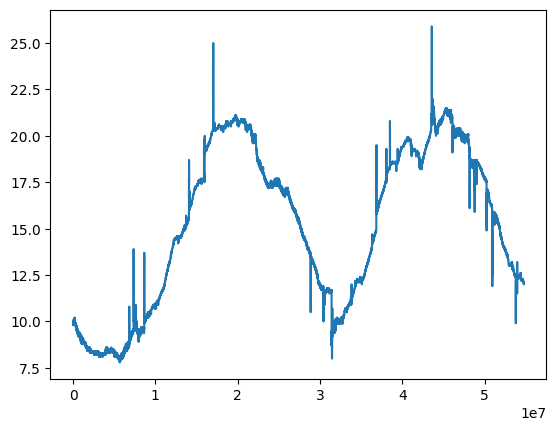

In [17]:
plt.plot(data['WS4']['Temperature (°C)'])

### Test Periods

In [10]:
tests = {}

tests['1'] = {'dates': [20210921, 20210922], 'times': [111500,  95000], 'text': 'air ventilation on'}

tests['2'] = {'dates': [20210922, 20210922], 'times': [111500,  16000], 'text': 'all lids opened/closed'}

tests['3'] = {'dates': [20210927, 20210927], 'times': [122600, 160300], 'text': 'central lid [1,2] open/closed and air ventilation on/off'}

tests['4'] = {'dates': [20211004, 20211004], 'times': [105200, 173000], 'text': 'central lid [1,2] opened/closed'}

tests['5'] = {'dates': [20211004, 20211008], 'times': [105200, 135500], 'text': ' air ventilation on/off'}

tests['6'] = {'dates': [20211011, 20211011], 'times': [113000, 170000], 'text': 'all lids open + air ventilation on/off'}

tests['7'] = {'dates': [20211025, 20211025], 'times': [142800, 153000], 'text': 'maintenance, no test'}

tests['8'] = {'dates': [20211029, 20211029], 'times': [150600, 152500], 'text': 'dehumidifier, ring, tuning'}

tests['9'] = {'dates': [20211105, 20211105], 'times': [101500, 102500], 'text': 'dehumidifier, ring, tuning'}


In [ ]:
events = []

for i in range(1, len(tests)+1):
    time, *_ = __get_timeaxis(
                           dates=tests[str(i)]['dates'],
                           times=tests[str(i)]['times'],
                           unit="date",
                           unitmode="relative",
                           dateformat="yyyymmdd",
                         )

    events.append(time)

### Plotting

In [12]:
def __make_plot_one_station(data, station, config):

    df = data.get(station)

    timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                       times=df.iloc[:,2], 
                                                       unit="date", 
                                                       unitmode="relative",
                                                      )

    N = 3
    font = 13

    fig, axes = plt.subplots(N,1, figsize=[15,10], sharex=True)

    for i in range(N):
        ydata = df.iloc[:,i+3]

#         axes[i].scatter(timeaxis, df.iloc[:,i+3], s=1, color='grey',lw=3, zorder=2)
        axes[i].plot(timeaxis, ydata, color=config['colors'][station], label=station, lw=1.5, zorder=2)
#         axes[i].fill_between(timeaxis, ydata-0.05, ydata+0.05, color='gray', alpha=0.4)     

        axes[i].grid(ls="--",color='grey', zorder=0)
        axes[i].legend(loc="upper right")

        if i == 0:
            axes[i].set_ylabel("Temperature (°C)",fontsize=font)
        elif i == 1:
            axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
        elif i == 2:
            axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
            axes[i].set_xlim(timeaxis[0], timeaxis[-1])

        axes[N-1].set_xticklabels(ticklabels)
        axes[N-1].set_xticks(ticks)
        axes[N-1].set_xlabel(text, fontsize=font)

    plt.show();
    return fig

In [12]:
fig = __make_plot_one_station(data, 'WS1', config);

del fig

In [13]:
def __make_plot_all_stations(data, config):

    N = 3
    font = 13
    datasize = 0

    fig, axes = plt.subplots(N, 1, figsize=[15,10], sharex=True)

    plt.subplots_adjust(hspace=0.05)

    max_val, min_val = np.zeros(N)*np.nan, np.zeros(N)*np.nan

    for station in data.keys():

        df = data.get(station)

        for u in range(3):
            maximum = df.iloc[:,u+3].dropna().max()
            minimum = df.iloc[:,u+3].dropna().min()
            if maximum > max_val[u] or np.isnan(max_val[u]):
                max_val[u] = maximum
            if minimum < min_val[u] or np.isnan(min_val[u]):
                min_val[u] = minimum

        timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1],
                                                           times=df.iloc[:,2],
                                                           unit="days", 
                                                           unitmode="relative",
                                                          )

        # select ticks and ticklabels for longest data series
        if df.shape[0] > datasize:
            datasize = df.shape[0]
            xticks = ticks
            xlabels = ticklabels
            timeaxis_min, timeaxis_max = timeaxis[0], timeaxis[-1]

        # plot data and adjust axes automatically
        for i in range(N):
            axes[i].plot(timeaxis, df.iloc[:,i+3].rolling(300).mean(), color=config['colors'][station], lw=1.5, zorder=2, label=station)

            axes[i].grid(ls="--",color='grey', zorder=0)

            if i == 0:
                axes[i].set_ylabel("Temperature (°C)",fontsize=font)
            elif i == 1:
                axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
            elif i == 2:
                axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
                axes[i].set_xlim(timeaxis_min, timeaxis_max)

            axes[N-1].set_xticklabels(xlabels)
            axes[N-1].set_xticks(xticks)
            axes[N-1].set_xlabel(text, fontsize=font)
            axes[N-1].legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -0.2), fancybox=True)

        ## adjust y-limits
#     for k in range(N):
#         axes[k].set_ylim(min_val[k]-0.005*min_val[k], max_val[k]+0.005*min_val[k])

    plt.show();
    return fig


 -> generate time axis


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]

 -> generate time axis
[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]

 -> generate time axis
[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]

 -> generate time axis
[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]

 -> generate time axis
[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]

 -> generate time axis
[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]

 -> generate time axis
[0.00000000e+00 1.15740741e-05 2.31481481e-05 ... 9.99965278e-01
 9.99976852e-01 9.99988426e-01]


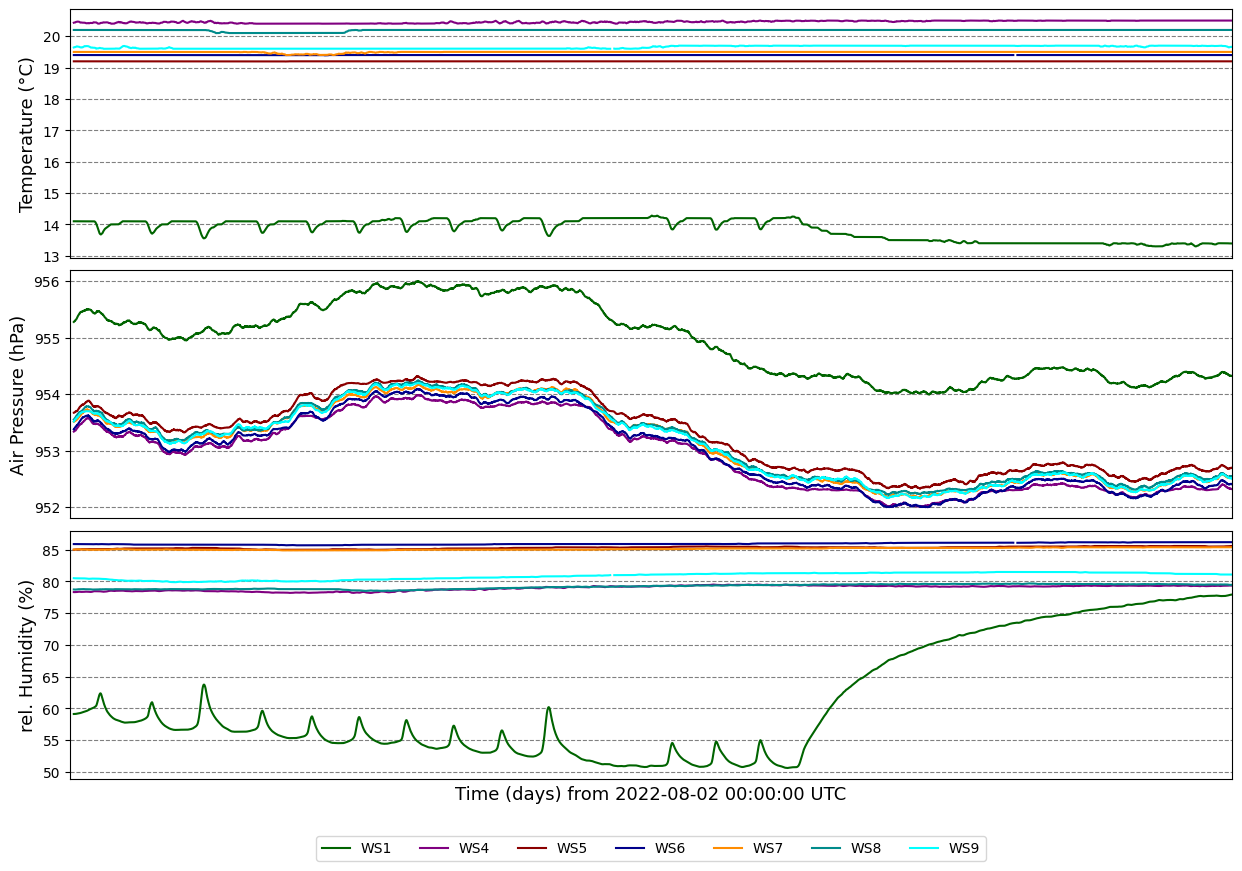

In [13]:
fig = __make_plot_all_stations(data, config);

fig.savefig(config['path_to_figs']+f"WROMY_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')

del fig

### Include FURT

In [14]:
def __make_plot_all_stations_and_furt(data, furt, config, events=None):
    
    N = 3
    font = 13
    datasize = 0
    
    fig, axes = plt.subplots(N,1, figsize=[15,10], sharex=True)
    
    plt.subplots_adjust(hspace=0.1)
    
    max_val, min_val = np.zeros(N)*np.nan, np.zeros(N)*np.nan
    
    timeaxis_furt, ticks_furt, ticklabels_furt, text_furt = __get_timeaxis(
                                                                           dates=furt.iloc[:,0], 
                                                                           times=furt.iloc[:,1], 
                                                                           unit='date', 
                                                                           unitmode="absolute",
                                                                           dateformat="ddmmyy",
                                                                          )    
    for station in data.keys():
        
        df = data.get(station)

        for u in range(3):
            maximum = df.iloc[:,u+3].dropna().max()
            minimum = df.iloc[:,u+3].dropna().min()
            if maximum > max_val[u] or np.isnan(max_val[u]):
                max_val[u] = maximum
            if minimum < min_val[u] or np.isnan(min_val[u]):
                min_val[u] = minimum
            
        timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                           times=df.iloc[:,2], 
                                                           unit='date', 
                                                           unitmode="absolute",
                                                           dateformat="yyyymmdd",
                                                          )


        ## select ticks and ticklabels for longest data series
        if df.shape[0] > datasize:
            datasize = df.shape[0]
            xticks = ticks
            xlabels = ticklabels
            timeaxis_min, timeaxis_max = timeaxis[0], timeaxis[-1]
        
#         print(xticks, xlabels, ticklabels)
#         print(len(timeaxis_furt), timeaxis_furt[0], timeaxis_furt[-1], len(timeaxis), timeaxis[0], timeaxis[-1])
    
        ## plot data and adjust axes automatically
        for i in range(N):
            
#             axes[i].scatter(timeaxis, df.iloc[:,i+3], s=1, color='grey',lw=3, zorder=2)
#             axes[i].plot(timeaxis, df.iloc[:,i+3], color=config['colors'][station], lw=1.5, zorder=2, label=station)
            axes[i].plot(timeaxis, df.iloc[:,i+3].rolling(60).mean(), color=config['colors'][station], lw=1.5, zorder=2, label=station)

            if station == list(data.keys())[-1]:
                axes[i].plot(timeaxis_furt, furt.iloc[:,i+2], color='darkgrey', lw=1.5, zorder=1, label="FURT")
       
            axes[i].grid(ls="--",color='grey', zorder=0)
            
            if i == 0:
                axes[i].set_ylabel("Temperature (°C)",fontsize=font)
            elif i == 1:
                axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
            elif i == 2:
                axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
                axes[i].set_xlim(timeaxis_min, timeaxis_max)

#             axes[N-1].set_xticklabels(xlabels[::4], fontsize=font-2)
#             axes[N-1].set_xticks(xticks[::4])
            axes[N-1].set_xticks(xticks)
            axes[N-1].set_xticklabels(xlabels, fontsize=font-2)
            axes[N-1].set_xlabel(text, fontsize=font)
            axes[N-1].legend(loc='upper center', ncol=7+1, bbox_to_anchor=(0.5, -0.2), fancybox=True, fontsize=font-2)

            if events:
                for event in events:
#                     axes[i].axvline(event, color='r', zorder=0, ls="-.")
                    axes[i].axvspan(event[0], event[1], color="lightgrey", alpha=0.4, zorder=1)
          
        ## adjust y-limits
#     for k in range(N):
#         axes[k].set_ylim(min_val[k]-0.005*min_val[k], max_val[k]+0.005*min_val[k])
        
    plt.show();
    return fig


 -> generate time axis
  -> Formating: date <ddmmyy> -> <yyyymmdd>

 -> generate time axis


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



 -> generate time axis

 -> generate time axis

 -> generate time axis

 -> generate time axis

 -> generate time axis

 -> generate time axis


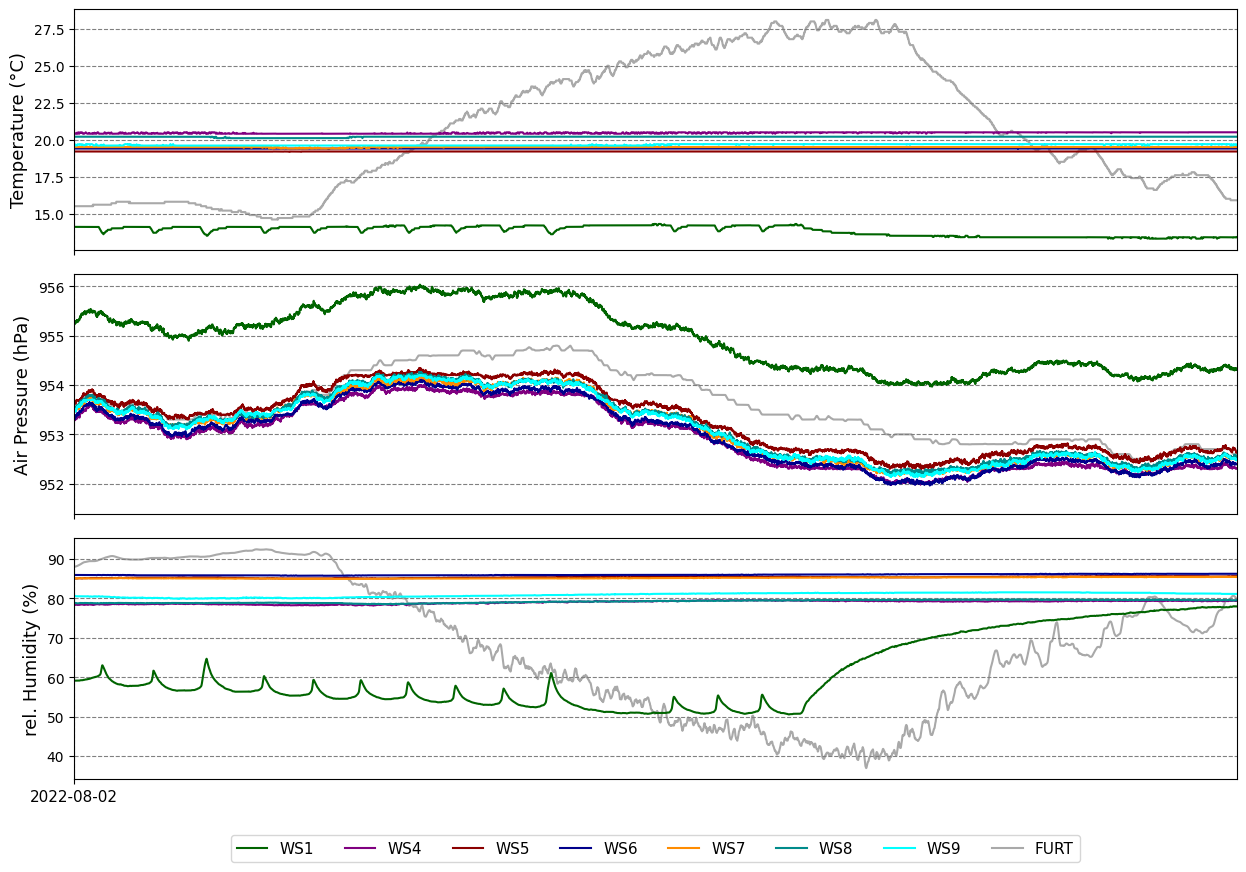

In [14]:
fig = __make_plot_all_stations_and_furt(data, furt, config, events=None);

fig.savefig(config['path_to_figs']+f"WROMY_FURT_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')

del fig

### RADON DATA

Fireware des Wave Radon am 22.09.2021 via App aktualisiert. Hiermit hat sich der Wert des RADON LTA der zuvor immer 0 war plötzlich geändert. Ob es hier auch einen Einfluss auf die STA Messung gab ist nicht klar. Und ob somit die Werte vor dem 22.09.2021 für den STA aussagekräftig sind ist offen.  

In [15]:
config2 = config.copy()

config2['channel'] = 'RDN'
config2['resample'] = 4

radon = __read_wromy_data(config2)
# df_new = __indicate_gaps_with_nan(radon, config2)
radon.insert(0, 'Seconds', np.zeros(radon.shape[0]))
radon = __processing(radon, config2)
radon['Date'] = radon['Date'].astype(int)
radon

  0%|          | 0/2 [00:00<?, ?it/s]

   -> Done 

   -> Filter: rooling mean 40!
   -> Resampling: keep every 4nth sample!


,Seconds,Date,Time (UTC),Humidity (%rH),Radon ST avg (Bq/m3),Radon LT avg (Bq/m3),Temperature (degC)
0,0.0,20220802,2,NaN,NaN,NaN,13.41
4,0.0,20220802,410,NaN,NaN,NaN,13.41
8,0.0,20220802,818,NaN,NaN,NaN,13.42
12,0.0,20220802,1227,NaN,NaN,NaN,13.43
16,0.0,20220802,1636,NaN,NaN,NaN,13.43
...,...,...,...,...,...,...,...
1372,0.0,20220802,233928,83.725,1584.0,1280.0,13.26
1376,0.0,20220802,234336,83.775,1584.0,1280.0,13.26
1380,0.0,20220802,234744,83.825,1584.0,1280.0,13.26
1384,0.0,20220802,235152,83.875,1584.0,1280.0,13.26



 -> generate time axis


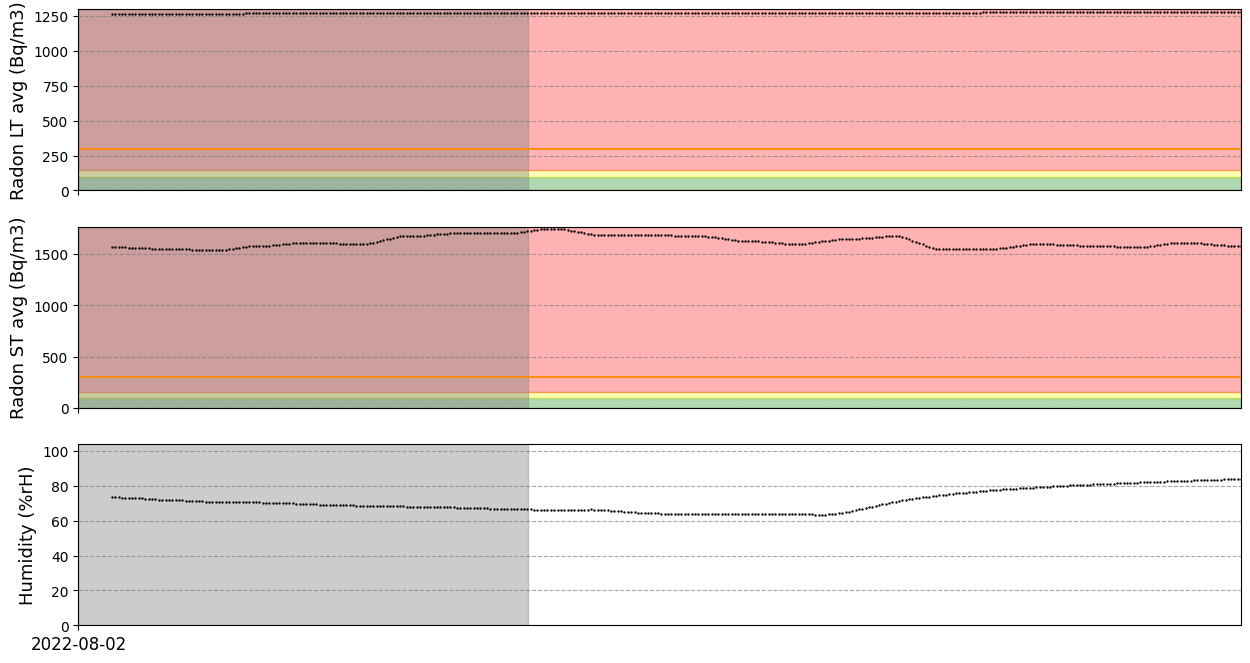

In [16]:
def __makeplot_radon(data, events=None):

    data_to_plot = [5,4,3]
    
    N = len(data_to_plot)
    font = 13
    datasize = 0
    
    
    timeaxis, ticks, ticklabels, text = __get_timeaxis(
                                                       dates=data.iloc[:,1], 
                                                       times=data.iloc[:,2], 
                                                       unit="date", 
                                                       unitmode="relative",
                                                       dateformat="yyyymmdd",
                                                      )  
    
    
    fig, axes = plt.subplots(N,1, figsize=(15,8), sharex=True)
    
    for i in range(N):
    
#         axes[i].plot(timeaxis, data.iloc[:,data_to_plot[i]], label=data.columns[data_to_plot[i]], color='k', zorder=2)
        axes[i].scatter(timeaxis, data.iloc[:,data_to_plot[i]], s=0.5, label=data.columns[data_to_plot[i]], color='k', zorder=2)

        axes[i].grid(ls="--", color='grey', zorder=0, alpha=0.7)

        axes[i].set_ylabel(data.columns[data_to_plot[i]], fontsize=font)

        axes[i].set_ylim(0, np.nanmax(data.iloc[:,data_to_plot[i]])+20)

        if i in range(2):
            axes[i].axhspan(0,100, color='green', alpha=0.3, zorder=0)
            axes[i].axhspan(100,150, color='yellow', alpha=0.3, zorder=0)
            axes[i].axhspan(150,np.nanmax(data.iloc[:,data_to_plot[i]])+20, color='red', alpha=0.3, zorder=0)
        
            axes[i].axhline(300, color='darkorange', alpha=0.9, zorder=1)
        
        if events:
            for event in events:
                if UTCDateTime(event[0]) > timeaxis[0]:
                    axes[i].axvspan(event[0], event[1], color="grey", alpha=0.4, zorder=0)


    axes[N-1].set_xticks(ticks[::2]) 
    axes[N-1].set_xticklabels(ticklabels[::2], fontsize=font-1)
    axes[N-1].set_xlabel(text, fontsize=font)
    
    axes[N-1].set_xlim(timeaxis[0], timeaxis[-1])
    
    
    return fig
    
__makeplot_radon(radon, events=events);